# Continuous Control

---


### 1. Start the Environment

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import torch

from ddpg_agent import Agent

import matplotlib.pyplot as plt
%matplotlib inline

import platform

In [2]:
platform.system()

'Linux'

In [3]:
filename = ''
if 'linux' in platform.system().lower():
        print('Linux')
        filename = 'Reacher.x86_64'

if 'darwin' in platform.system().lower():
        print('Mac')
        filename = 'Reacher.app'

if 'windows' in platform.system().lower(): # Not tested
        print('Win')
        filename = 'Reacher.exe'

Linux


In [4]:
# 20 agents
# filename ='Reacher_Linux_NoVis/Reacher.x86_64'


In [5]:
assert filename != '', "Please write the correct filename (and path if needed) to the Banana application in the cell below and uncomment."

In [6]:
# Please write the correct filename (and path if needed) to the Banana application
# filename = ''

In [7]:
env = UnityEnvironment(file_name=filename)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [8]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [9]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Deep Deterministic Policy Gradient aka DDPG

In [10]:
# Whether to run the environment in training or inference mode
# Training mode is faster than inference mode, visualization-wise.
train_mode = True

In [11]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=10, num_agents=num_agents)

In [12]:
def ddpg(n_episodes=300, max_t=1000):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
    """
    
    all_episodes_scores = []                                     # list containing scores from each episode
    scores_window = deque(maxlen=100)                            # last 100 scores
    first_time = False
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name]
        states = env_info.vector_observations
        agent.reset()
        score_list = np.zeros(num_agents) # score for the episode <--- before [] and issue with score_list == 0.00. TODO why?
        
        for t in range(max_t):
            actions = agent.act(states) # No need to clip as act return clipped actions between -1 and 1
            
            env_info = env.step(actions)[brain_name]           # send the action to the environment
            next_states = env_info.vector_observations
            rewards = env_info.rewards                         # get the reward
            dones = env_info.local_done                        # see if episode has finished
            
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            score_list += rewards
            
            if np.any(dones):
                break
                
        avg_ep_score = np.mean(score_list) # Average episode score
        scores_window.append(avg_ep_score) # Last 100 episodes
        
        all_episodes_scores.append(avg_ep_score)

        print('\rEpisode {}\tEpisode Score: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, avg_ep_score, np.mean(all_episodes_scores)), end="")
        if avg_ep_score >= 30.0 and not first_time:
            print('\rFirst episode to reach 30.0+ {}\tEpisode Score: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, avg_ep_score, np.mean(all_episodes_scores)))
            first_time = True
        if i_episode % 10 == 0:
            print('\rEpisode {}\tEpisode Score: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, avg_ep_score, np.mean(all_episodes_scores)))
        if np.mean(scores_window) >= 30.0:
            if i_episode >= 100:
                print('\nEnvironment solved after {:d} episodes!\tAverage last 100 Episodes Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
                torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_in-{}_s-{}.pth'.format(i_episode, np.mean(scores_window)))
                torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_in-{}_s-{}.pth'.format(i_episode, np.mean(scores_window)))
            break
    return all_episodes_scores

In [13]:
import time
start = time.time()

In [14]:
print("Number of agents {}".format(num_agents))
scores = ddpg(max_t=1000)

Number of agents 20


Episode 10	Episode Score: 1.78	Average Score: 0.84
Episode 20	Episode Score: 7.72	Average Score: 2.52
First episode to reach 30.0+ 29	Episode Score: 32.54	Average Score: 8.05
Episode 30	Episode Score: 31.15	Average Score: 8.82
Episode 40	Episode Score: 38.33	Average Score: 15.94
Episode 50	Episode Score: 39.16	Average Score: 20.51
Episode 60	Episode Score: 38.62	Average Score: 23.56
Episode 70	Episode Score: 38.84	Average Score: 25.73
Episode 80	Episode Score: 38.74	Average Score: 27.31
Episode 90	Episode Score: 38.15	Average Score: 28.53
Episode 100	Episode Score: 38.67	Average Score: 29.53
Episode 102	Episode Score: 38.76	Average Score: 29.71
Environment solved after 102 episodes!	Average last 100 Episodes Score: 30.29


In [15]:
end = time.time() - start
print("The training was done in {:.2f} seconds.".format(end))

The training was done in 1097.02 seconds.


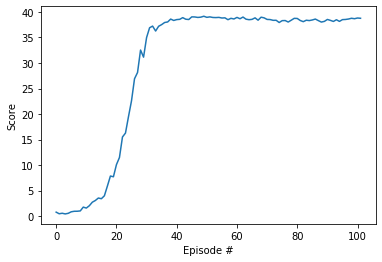

In [16]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

When finished, you can close the environment.

In [17]:
env.close()